<a href="https://colab.research.google.com/github/fcignoli/horneros/blob/main/bifurcaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from scipy.io import wavfile
import matplotlib
from scipy.integrate import odeint
import scipy.fftpack
from matplotlib.widgets import Slider
from matplotlib.gridspec import GridSpec
from scipy import signal
import ipywidgets as widgets
from IPython.display import display

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


# Modelo de ecuación diferencial
def f_model(v, t, kappa, beta):
    x, y = v
    gamma = 6500  # Frecuencia ~1 kHz
    kappa_ref = 1e-6  # Valor de referencia para escalar f0
    f0 = (gamma**2) * kappa_ref * 0.1  # f0 ~ 3947.6 (ajustable)
    g2 = gamma * gamma
    dxdt = y
    dydt = (- g2 * kappa * x - gamma * (x**2) * y + beta * gamma * y + f_0)
    return [dxdt, dydt]


#integrador
def rk4(dxdt, x, t, dt, *args, **kwargs):
    x = np.asarray(x)
    k1 = np.asarray(dxdt(x, t, *args, **kwargs))*dt
    k2 = np.asarray(dxdt(x + k1*0.5, t, *args, **kwargs))*dt
    k3 = np.asarray(dxdt(x + k2*0.5, t, *args, **kwargs))*dt
    k4 = np.asarray(dxdt(x + k3, t, *args, **kwargs))*dt
    return x + (k1 + 2*k2 + 2*k3 + k4)/6

#FFT
def create_fft(sol,dt):
    # Number of samplepoints
    N = len(sol[:,1])
    # sample spacing
    yf = scipy.fftpack.fft(sol[:,1])
    xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
    return xf, 2.0/N * np.abs(yf[:N//2])

#espectograma
def get_spectrogram(data, sampling_rate, window=1024, overlap=1/1.1,
                    sigma=102.4, fmax=8000, drange=6):
    fu, tu, Sxx = signal.spectrogram(data, sampling_rate, nperseg=window,
                                     noverlap=window*overlap,
                                     window=signal.get_window
                                     (('gaussian', sigma), window),
                                     scaling='spectrum')
    Sxx = np.clip(Sxx, a_min=np.amax(Sxx)/10**drange, a_max=np.amax(Sxx))
    return fu, tu, Sxx
#suavizador
def smooth_square_wave(t, t_start, duration, transition=0.1):
    """
    Generates a smooth semi-period of a square wave centered at t_center with a given duration.
    """
    t_end = t_start + duration

    y = 1 / (1 + np.exp(-(t - t_start) / transition)) - 1 / (1 + np.exp(-(t - t_end) / transition))

    return y

In [36]:
# Función para actualizar la gráfica
def plot_system(kappa, beta):
    dt = 0.000001
    t = np.arange(0, .05, dt)
    vars0 = [0.1, 0.1]
    sol = odeint(f_model, vars0, t, args=(kappa, beta))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Espacio de fases
    axes[0].plot(sol[:, 0], sol[:, 1], lw=2)
    axes[0].scatter(vars0[0], vars0[1], color='orange', s=30, zorder=100)
    axes[0].axhline(0, color='k')
    axes[0].axvline(0, color='k')
    axes[0].set_xlabel('$x$', fontsize=14)
    axes[0].set_ylabel('$y$', fontsize=14)

    # FFT
    xf, yf = create_fft(sol, dt)
    axes[1].plot(xf / 1000, yf)
    axes[1].set_xlim([0, 15])
    axes[1].set_xlabel("Frequency (kHz)", fontsize=14)
    axes[1].set_ylabel("FFT(y)", fontsize=14)

    plt.show()

# Widgets interactivos
kappa_slider = widgets.FloatSlider(min=0, max=0.25e-7, step=1e-9, value=0, description=r'$\kappa$')
beta_slider = widgets.FloatSlider(min=0, max=0.5e7, step=1e5, value=0, description=r'$\beta$')

ui = widgets.VBox([kappa_slider, beta_slider])
out = widgets.interactive_output(plot_system, {'kappa': kappa_slider, 'beta': beta_slider})

display(ui, out)


Output()

Error in callback <function _draw_all_if_interactive at 0x7e57e10fa480> (for post_execute):


/usr/local/lib/python3.11/dist-packages/matplotlib/ticker.py:2176: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/usr/local/lib/python3.11/dist-packages/matplotlib/ticker.py:2218: RuntimeWarning: overflow encountered in scalar subtract
  high = edge.ge(_vmax - best_vmin)
/usr/local/lib/python3.11/dist-packages/matplotlib/ticker.py:2034: RuntimeWarning: invalid value encountered in scalar divmod
  d, m = divmod(x, self.step)


ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

<Figure size 1000x400 with 2 Axes>

Muestreo: 44100 Hz
Forma de la señal: (598016,)


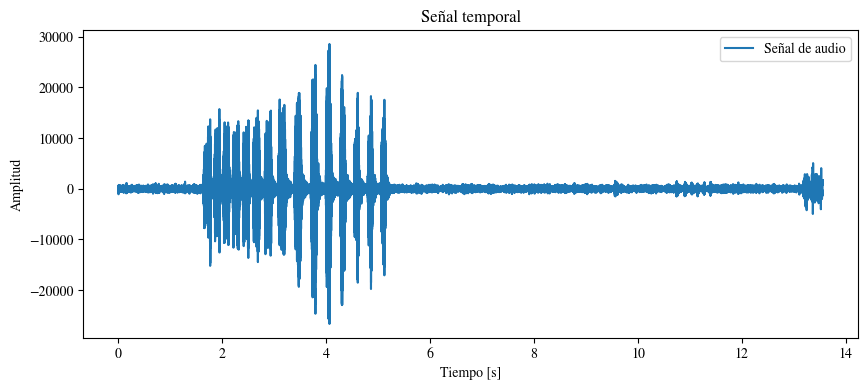

[]

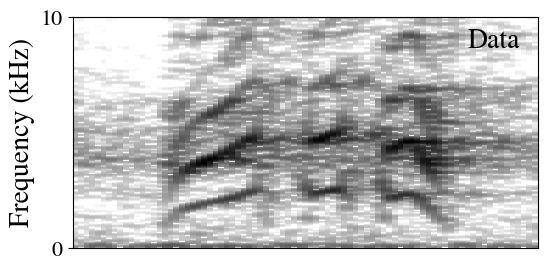

In [41]:
#visualizar el audio de referencia
from scipy.io import wavfile
import os

# Ruta del archivo (ajusta el nombre si es diferente)
audio_filename = "archivo_audio.wav"  # Reemplaza con el nombre real
audio_path = f"/content/{audio_filename}"

# Verificar si el archivo existe
if os.path.exists(audio_path):
    # Leer archivo de audio
    f_s, audio_data = wavfile.read(audio_path)
    print(f"Muestreo: {f_s} Hz")
    print(f"Forma de la señal: {audio_data.shape}")
else:
    print(f"Error: No se encontró el archivo {audio_filename}")

# Graficar la señal en el dominio del tiempo
plt.figure(figsize=(10, 4))
time = np.linspace(0, len(audio_data) / f_s, num=len(audio_data))
plt.plot(time, audio_data, label="Señal de audio")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Señal temporal")
plt.legend()
plt.show()

#recorto

start_time = 1.8
end_time = 2

# Convertir los tiempos a índices de muestras
start_sample = int(start_time * f_s)  # Índice para 1.5 segundos
end_sample = int(end_time * f_s)      # Índice para 3 segundos

# Extraer la porción del audio entre esos índices
audio_segment = audio_data[start_sample:end_sample]
audio_data = audio_segment
# Ahora, 'audio_segment' tiene los datos de audio entre 1.5 y 3 segundos


#espectograma
fsize=20
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

fu, tu, Sxx = get_spectrogram(audio_data, f_s)
Sxx = np.clip(Sxx, a_min=np.amax(Sxx)/200000, a_max = np.amax(Sxx))

ax.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto',
                  cmap='binary')

ax.text(0.85, 0.95, "Data",  transform=ax.transAxes, va='top', ha='left', fontsize=fsize)
ax.set_ylim([0, 10])
ax.set_yticks([0, 10])
ax.set_ylabel("Frequency (kHz)", fontsize=fsize)
ax.tick_params(axis='both', which='major', labelsize=fsize-4)
#ax.set_xlim([0, .15])
ax.set_xticks([])

# plt.savefig(save_folder_fig+"fig_sintesis_infant_downsweep_data_model.png", dpi=900)

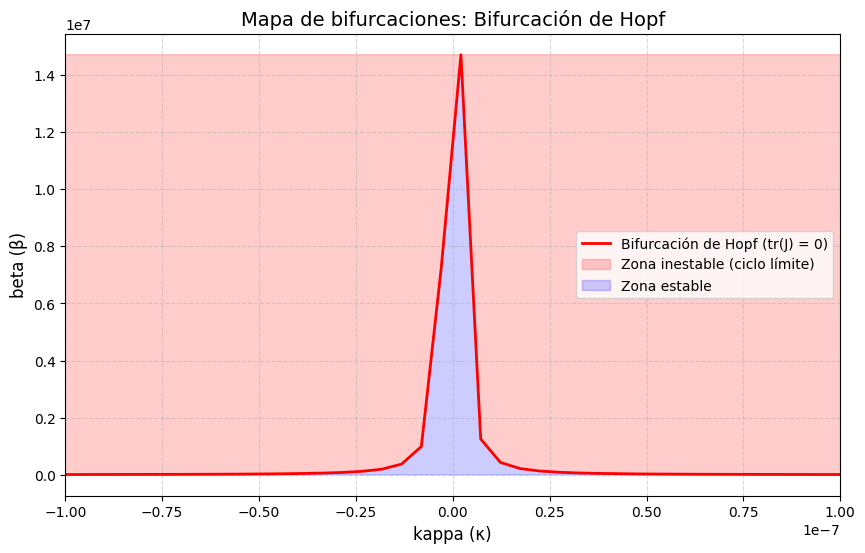

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros FIJOS (para escalar f0)
gamma = 6500  # Frecuencia ~1 kHz
kappa_ref = 1e-6  # Valor de referencia para escalar f0
f0 = (gamma**2) * kappa_ref * 0.1  # f0 ~ 3947.6 (ajustable)

# Rango de kappa (para el gráfico)
kappa = np.linspace(-1e-7, 5e-6, 1000)
beta_hopf = (f0**2) / (gamma**3 * kappa**2)  # Curva de Hopf

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(kappa, beta_hopf, 'r-', linewidth=2, label='Bifurcación de Hopf (tr(J) = 0)')

# Rellenar zonas (ajusta los límites de y)
plt.fill_between(kappa, beta_hopf, beta_hopf.max(), color='red', alpha=0.2, label='Zona inestable (ciclo límite)')
plt.fill_between(kappa, 0, beta_hopf, color='blue', alpha=0.2, label='Zona estable')

# Ajustes de ejes
plt.xlabel('kappa (κ)', fontsize=12)
plt.ylabel('beta (β)', fontsize=12)
plt.title('Mapa de bifurcaciones: Bifurcación de Hopf', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Límites para capturar la curva (¡ajusta estos valores!)
#plt.ylim(0, 0.4e7)  # Nuevo rango de beta
plt.xlim(kappa.min(), 0.1e-6)
plt.show()

<ipython-input-39-bed23c92c73b>:21: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(f_model, v0, t, args=(kappa, beta))


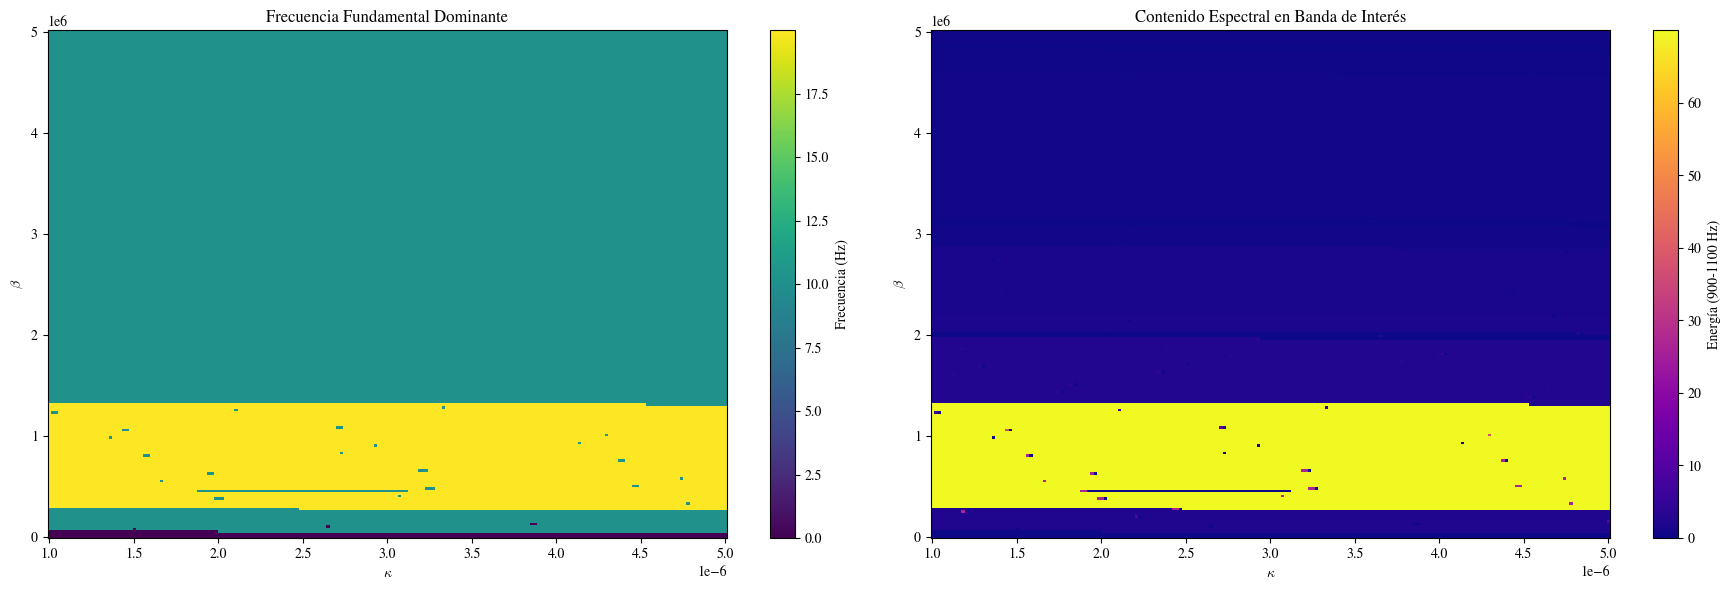

In [39]:
import numpy as np
from scipy.integrate import odeint
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Parámetros del sistema
gamma = 6283       # Frecuencia característica ~1 kHz
f0 = 39.5          # Amplitud del forzamiento
t = np.linspace(0, 0.1, 10000)  # Tiempo de simulación (100 ms)
v0 = [0, 0]        # Condiciones iniciales

# Definición del modelo
def f_model(v, t, kappa, beta):
    x, y = v
    dxdt = y
    dydt = - (gamma**2) * kappa * x - gamma * (x**2) * y + beta * gamma * y + f0
    return [dxdt, dydt]

# Función para análisis espectral
def get_spectral_properties(kappa, beta):
    sol = odeint(f_model, v0, t, args=(kappa, beta))
    x = sol[:, 0]
    N = len(t)
    yf = fft(x)
    xf = fftfreq(N, t[1] - t[0])[:N//2]
    power = np.abs(yf[:N//2])**2
    power /= np.max(power)  # Normalización
    dominant_freq = xf[np.argmax(power)]
    return dominant_freq, power, xf

# Rango de parámetros (kappa, beta)
kappa_vals = np.linspace(1e-6, 5e-6, 200)
beta_vals = np.linspace(0, 0.5e7, 200)
K, B = np.meshgrid(kappa_vals, beta_vals)

# Preallocar matrices para resultados
freq_map = np.zeros_like(K)
spectral_energy = np.zeros_like(K)

# Llenar las matrices (puede tardar unos segundos)
for i in range(len(kappa_vals)):
    for j in range(len(beta_vals)):
        kappa = K[i, j]
        beta = B[i, j]
        dominant_freq, power, xf = get_spectral_properties(kappa, beta)
        freq_map[i, j] = dominant_freq
        mask = (xf >= 800) & (xf <= 1500)  # Banda de 900-1100 Hz
        spectral_energy[i, j] = np.sum(power[mask])

# Crear figura con dos subplots
plt.figure(figsize=(18, 6))

# Mapa de frecuencia fundamental
plt.subplot(1, 2, 1)
plt.pcolormesh(K, B, freq_map, shading='auto', cmap='viridis')
plt.colorbar(label='Frecuencia (Hz)')
plt.xlabel('$\kappa$')
plt.ylabel('$\\beta$')
plt.title('Frecuencia Fundamental Dominante')

# Mapa de energía espectral
plt.subplot(1, 2, 2)
plt.pcolormesh(K, B, spectral_energy, shading='auto', cmap='plasma')
plt.colorbar(label='Energía (900-1100 Hz)')
plt.xlabel('$\kappa$')
plt.ylabel('$\\beta$')
plt.title('Contenido Espectral en Banda de Interés')

plt.tight_layout()
plt.show()